# Подготовка данных

In [1]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('TrainPatterns.csv')
train.head()

,CatalogStId,SidStarID,Number,RouteL,ProcedureType,StdDevDist,MeanDist,StdDevDistm1,MeanDistm1,MeanAzChangem1,StdAzChangem1,StdDevDistToLast,MeanDistToLast,LastAnglChange
0,1162,145,9,4,veer,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
1,1162,146,9,4,veer,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
2,1162,191,7,4,veer,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
3,1162,193,7,4,veer,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
4,1162,194,7,4,veer,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539


In [7]:
train.shape

(2100, 14)

In [12]:
train.isna().any().sum()

0

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CatalogStId       2100 non-null   int64  
 1   SidStarID         2100 non-null   int64  
 2   Number            2100 non-null   int64  
 3   RouteL            2100 non-null   int64  
 4   ProcedureType     2100 non-null   object 
 5   StdDevDist        2100 non-null   float64
 6   MeanDist          2100 non-null   float64
 7   StdDevDistm1      2100 non-null   float64
 8   MeanDistm1        2100 non-null   float64
 9   MeanAzChangem1    2100 non-null   float64
 10  StdAzChangem1     2100 non-null   float64
 11  StdDevDistToLast  2100 non-null   float64
 12  MeanDistToLast    2100 non-null   float64
 13  LastAnglChange    2100 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 229.8+ KB


In [68]:
X = train.drop(columns=['ProcedureType'])
y = train['ProcedureType']

## Кодировка целевой переменной

In [69]:
y.unique()

array(['veer', 'trombone', 'ordinary'], dtype=object)

In [70]:
from sklearn.preprocessing import LabelEncoder

target_le = LabelEncoder().fit(y)

In [71]:
target_le.classes_

array(['ordinary', 'trombone', 'veer'], dtype=object)

In [72]:
y = target_le.transform(y)

In [73]:
target_le.inverse_transform([0, 1, 2])

array(['ordinary', 'trombone', 'veer'], dtype=object)

In [74]:
X.head()

,CatalogStId,SidStarID,Number,RouteL,StdDevDist,MeanDist,StdDevDistm1,MeanDistm1,MeanAzChangem1,StdAzChangem1,StdDevDistToLast,MeanDistToLast,LastAnglChange
0,1162,145,9,4,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
1,1162,146,9,4,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
2,1162,191,7,4,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
3,1162,193,7,4,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539
4,1162,194,7,4,3.191862,19.222117,1.73035,17.520067,41.005884,0.0,1.593168,24.06125,106.911539


# Моделирование

## Логистическая регрессия

In [169]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import MinMaxScaler, StandardScaler

col_dropper = ColumnTransformer([
    ('drop_ids', 'drop', ['CatalogStId', 'SidStarID']),
], remainder='passthrough')

prep_pipe = Pipeline([
    ('dropper', col_dropper),
    ('selector', SelectKBest()),
    ('scaler', StandardScaler())
])

In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Тюнинг гиперпараметров

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from scipy.stats import randint, uniform

lr_pipe = Pipeline([
    ('prep', prep_pipe),
    ('logreg', LogisticRegression())
])

param_grid = {
    'prep__selector__k': [7, 8, 9, 10, 11],
    'prep__selector__score_func': [chi2, f_classif, mutual_info_classif],
    'logreg__C': uniform(1, 10),
    'logreg__max_iter': [5000]
}

gs = RandomizedSearchCV(
    lr_pipe,
    param_distributions=param_grid,
    n_iter=1000,
    n_jobs=-1,
    cv=5,
    verbose=2,
    refit=True
)

gs.fit(X_train, y_train)
gs.best_score_, gs.best_params_
# logreg = LogisticRegression(max_iter=5000)
# logreg.fit(X_train, y_train)
# logreg.score(X_train, y_train), logreg.score(X_test, y_test)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


(0.9802721088435373,
 {'logreg__C': 1.5361203448195362,
  'logreg__max_iter': 5000,
  'prep__selector__k': 8,
  'prep__selector__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>})

In [180]:
logreg = gs.best_estimator_

### Выборка признаков, дающих лучший результат

In [181]:
names = logreg.named_steps['prep'].named_steps['dropper'].get_feature_names_out()
names

array(['remainder__Number', 'remainder__RouteL', 'remainder__StdDevDist',
       'remainder__MeanDist', 'remainder__StdDevDistm1',
       'remainder__MeanDistm1', 'remainder__MeanAzChangem1',
       'remainder__StdAzChangem1', 'remainder__StdDevDistToLast',
       'remainder__MeanDistToLast', 'remainder__LastAnglChange'],
      dtype=object)

In [182]:
selected_names = logreg.named_steps['prep'].named_steps['selector'].get_feature_names_out()
selected_names

array(['x2', 'x3', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10'], dtype=object)

In [183]:
selected_featues = []

for selected_name in selected_names:
    selected_name = int(selected_name[1:])
    selected_featues.append(names[selected_name][11:])
    
selected_featues

['StdDevDist',
 'MeanDist',
 'StdDevDistm1',
 'MeanDistm1',
 'MeanAzChangem1',
 'StdDevDistToLast',
 'MeanDistToLast',
 'LastAnglChange']

In [184]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=logreg.predict(X_test))

array([[527,   4,   7],
       [  7,   9,   0],
       [  1,   0,  75]], dtype=int64)

In [185]:
logreg.fit(X, y)
logreg.score(X, y)

0.9757142857142858

In [186]:
test = pd.read_csv('TestPatterns.csv')
test.head()

,CatalogStId,SidStarID,Number,RouteL,ProcedureType,StdDevDist,MeanDist,StdDevDistm1,MeanDistm1,MeanAzChangem1,StdAzChangem1,StdDevDistToLast,MeanDistToLast,LastAnglChange
0,2167,513,8,6,trombone,1.191977,10.517558,0.006818,9.984496,0.017087,0.001720,11.987564,25.370561,89.986418
1,2167,513,9,5,trombone,1.330951,10.653378,0.000266,9.987903,0.017332,0.002358,8.818147,21.238204,89.986418
2,2167,513,10,4,trombone,1.536762,10.875305,0.000040,9.988056,0.015665,0.000000,5.623555,17.474004,89.986418
3,2167,517,8,6,trombone,1.191977,10.517558,0.006818,9.984496,0.017087,0.001720,11.987564,25.370561,89.986418
4,2167,517,9,5,trombone,1.330951,10.653378,0.000266,9.987903,0.017332,0.002358,8.818147,21.238204,89.986418


In [187]:
test.shape

(2343, 14)

In [188]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CatalogStId       2343 non-null   int64  
 1   SidStarID         2343 non-null   int64  
 2   Number            2343 non-null   int64  
 3   RouteL            2343 non-null   int64  
 4   ProcedureType     2343 non-null   object 
 5   StdDevDist        2343 non-null   float64
 6   MeanDist          2343 non-null   float64
 7   StdDevDistm1      2343 non-null   float64
 8   MeanDistm1        2343 non-null   float64
 9   MeanAzChangem1    2343 non-null   float64
 10  StdAzChangem1     2343 non-null   float64
 11  StdDevDistToLast  2343 non-null   float64
 12  MeanDistToLast    2343 non-null   float64
 13  LastAnglChange    2343 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 256.4+ KB


In [189]:
X_t = test.drop(columns=['ProcedureType'])
y_t = test['ProcedureType']

In [190]:
y_t = target_le.transform(y_t)

### Оценка точности классификации

In [191]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_t, y_pred=logreg.predict(X_t))

0.9334186939820742

In [192]:
confusion_matrix(y_true=y_t, y_pred=logreg.predict(X_t))

array([[1899,   34,   29],
       [  88,   92,    0],
       [   5,    0,  196]], dtype=int64)

### Удаление шага автоматической выборки признаков из итогового оценщика

In [294]:
col_selector = ColumnTransformer([
    ('nothing', 'passthrough', selected_featues),
], remainder='drop')

prep_pipe_lr = Pipeline([
    ('selector', col_selector),
    ('scaler', StandardScaler())
])

In [298]:
logreg = Pipeline([
    ('prep', prep_pipe_lr),
    ('logreg', LogisticRegression(C=1.5361203448195362, max_iter=5000))
])

logreg.fit(X, y)

accuracy_score(y_true=y_t, y_pred=logreg.predict(X_t))

0.9334186939820742

## Дерево решений

In [195]:
col_selector = ColumnTransformer([
    ('nothing', 'passthrough', selected_featues),
], remainder='drop')

### Тюнинг гиперпараметров

In [225]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint, uniform

tree_pipe = Pipeline([
    ('prep', col_selector),
    ('tree', DecisionTreeClassifier())
])

param_grid = {
    'tree__max_depth': randint(1, 8),
    'tree__max_features': randint(2, 8),
    'tree__max_leaf_nodes': randint(2, 20)
}

gs_tree = RandomizedSearchCV(
    tree_pipe,
    param_distributions=param_grid,
    n_iter=1000,
    n_jobs=-1,
    cv=5,
    verbose=2,
    refit=True
)

gs_tree.fit(X_train, y_train)
gs_tree.best_score_, gs_tree.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


(0.9945578231292517,
 {'tree__max_depth': 6, 'tree__max_features': 7, 'tree__max_leaf_nodes': 17})

In [226]:
tree = gs_tree.best_estimator_

In [227]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=tree.predict(X_test))

array([[531,   0,   7],
       [  0,  16,   0],
       [  1,   0,  75]], dtype=int64)

In [228]:
accuracy_score(y_true=y_test, y_pred=tree.predict(X_test))

0.9873015873015873

In [229]:
tree.fit(X, y)
tree.score(X, y)

0.9966666666666667

### Оценка точности классификации

In [230]:
accuracy_score(y_true=y_t, y_pred=tree.predict(X_t))

0.9726845924029023

In [231]:
confusion_matrix(y_true=y_t, y_pred=tree.predict(X_t))

array([[1945,    8,    9],
       [  42,  138,    0],
       [   5,    0,  196]], dtype=int64)

In [243]:
t = tree.named_steps['tree']
feat_imps = dict(zip(selected_featues, t.feature_importances_))
feat_imps

{'StdDevDist': 0.03811070184386233,
 'MeanDist': 0.0,
 'StdDevDistm1': 0.0037882825432808873,
 'MeanDistm1': 0.010267472801813306,
 'MeanAzChangem1': 0.04823708864139131,
 'StdDevDistToLast': 0.7669407429133636,
 'MeanDistToLast': 0.0140608693527548,
 'LastAnglChange': 0.11859484190353364}

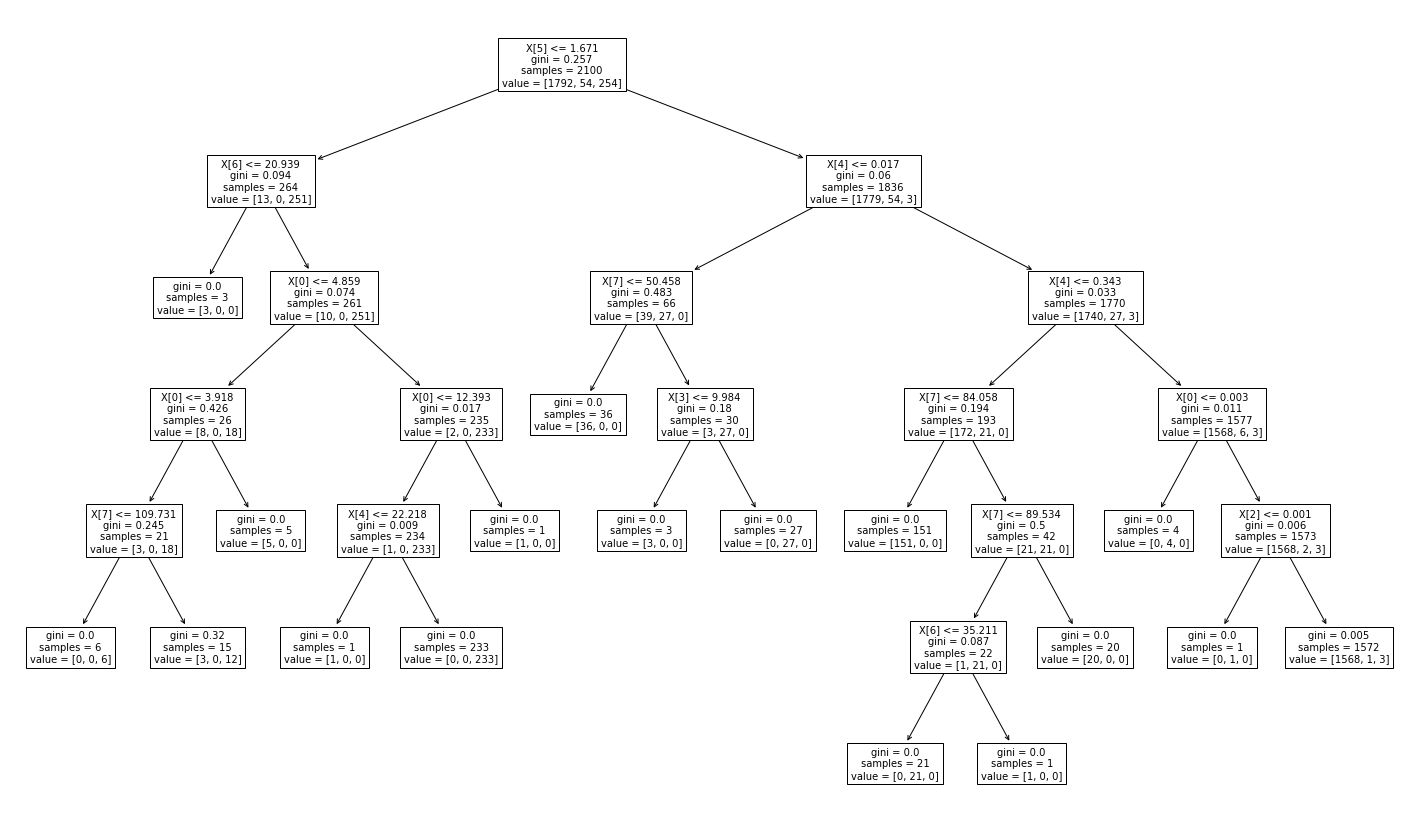

In [239]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25, 15))
plot_tree(tree.named_steps['tree'], ax=ax)
plt.show()

## Метод опорных векторов

In [244]:
prep_pipe_svm = Pipeline([
    ('selector', col_selector),
    ('scaler', StandardScaler())
])

### Тюнинг гиперпараметров

In [246]:
from sklearn.svm import SVC
from scipy.stats import reciprocal

svm_pipe = Pipeline([
    ('prep', prep_pipe_svm),
    ('svc', SVC(probability=True))
])

param_grid = {
    'svc__gamma': reciprocal(0.0001, 0.1),
    'svc__C': uniform(1, 10)
}

gs_svm = RandomizedSearchCV(
    svm_pipe,
    param_distributions=param_grid,
    n_iter=500,
    n_jobs=-1,
    cv=5,
    verbose=2,
    refit=True
)

gs_svm.fit(X_train, y_train)
gs_svm.best_score_, gs_svm.best_params_
# logreg = LogisticRegression(max_iter=5000)
# logreg.fit(X_train, y_train)
# logreg.score(X_train, y_train), logreg.score(X_test, y_test)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


(0.9829931972789115,
 {'svc__C': 8.302487522037492, 'svc__gamma': 0.09573157681224062})

In [247]:
svm = gs_svm.best_estimator_

In [248]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=svm.predict(X_test))

array([[525,   6,   7],
       [  6,  10,   0],
       [  0,   0,  76]], dtype=int64)

In [249]:
accuracy_score(y_true=y_test, y_pred=svm.predict(X_test))

0.9698412698412698

In [251]:
svm.fit(X, y)
svm.score(X, y)

0.9842857142857143

### Оценка точности классификации

In [252]:
accuracy_score(y_true=y_t, y_pred=svm.predict(X_t))

0.9466495945369184

In [253]:
confusion_matrix(y_true=y_t, y_pred=svm.predict(X_t))

array([[1902,   45,   15],
       [  42,  138,    0],
       [  23,    0,  178]], dtype=int64)

## Случайный лес

### Тюнинг гиперпараметров

In [284]:
from sklearn.ensemble import RandomForestClassifier

forest_pipe = Pipeline([
    ('prep', col_selector),
    ('forest', RandomForestClassifier(n_jobs=-1))
])

param_grid = {
    'forest__n_estimators': [50, 100, 150, 200, 250],
    'forest__max_depth': randint(1, 8),
    'forest__max_features': randint(2, 8),
    'forest__max_leaf_nodes': randint(2, 20)
}

gs_forest = RandomizedSearchCV(
    forest_pipe,
    param_distributions=param_grid,
    n_iter=500,
    n_jobs=-1,
    cv=5,
    verbose=2,
    refit=True
)

gs_forest.fit(X_train, y_train)
gs_forest.best_score_, gs_forest.best_params_
# logreg = LogisticRegression(max_iter=5000)
# logreg.fit(X_train, y_train)
# logreg.score(X_train, y_train), logreg.score(X_test, y_test)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


(0.9945578231292517,
 {'forest__max_depth': 7,
  'forest__max_features': 6,
  'forest__max_leaf_nodes': 13,
  'forest__n_estimators': 50})

In [285]:
forest = gs_forest.best_estimator_

In [286]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=forest.predict(X_test))

array([[533,   0,   5],
       [  1,  15,   0],
       [  1,   0,  75]], dtype=int64)

In [287]:
accuracy_score(y_true=y_test, y_pred=forest.predict(X_test))

0.9888888888888889

In [288]:
forest.fit(X, y)
forest.score(X, y)

0.9942857142857143

### Оценка точности классификации

In [289]:
accuracy_score(y_true=y_t, y_pred=forest.predict(X_t))

0.9731113956466069

In [290]:
confusion_matrix(y_true=y_t, y_pred=forest.predict(X_t))

array([[1946,    0,   16],
       [  42,  138,    0],
       [   5,    0,  196]], dtype=int64)

## Многослойный персептрон

In [313]:
prep_pipe_mlp = Pipeline([
    ('selector', col_selector),
    ('scaler', StandardScaler())
])

### Тюнинг гиперпараметров

In [323]:
from sklearn.neural_network import MLPClassifier

mlp_pipe = Pipeline([
    ('prep', prep_pipe_mlp),
    ('mlp', MLPClassifier())
])

param_grid = {
    'mlp__hidden_layer_sizes': [(50, 100), (100, 50), (100, 100), (50, 50, 50), (50, 50)],
    'mlp__activation': ['relu', 'logistic'],
    'mlp__solver': ['lbfgs'],
    'mlp__alpha': reciprocal(0.0001, 0.01),
    'mlp__max_iter': [500]
}


gs_mlp = RandomizedSearchCV(
    mlp_pipe,
    param_distributions=param_grid,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=2,
    refit=True
)

gs_mlp.fit(X_train, y_train)
gs_mlp.best_score_, gs_mlp.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


(0.9938775510204081,
 {'mlp__activation': 'relu',
  'mlp__alpha': 0.0020562482893099064,
  'mlp__hidden_layer_sizes': (100, 50),
  'mlp__max_iter': 500,
  'mlp__solver': 'lbfgs'})

In [324]:
mlp = gs_mlp.best_estimator_

In [325]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=mlp.predict(X_test))

array([[532,   1,   5],
       [  0,  16,   0],
       [  1,   0,  75]], dtype=int64)

In [326]:
accuracy_score(y_true=y_test, y_pred=mlp.predict(X_test))

0.9888888888888889

In [327]:
mlp.fit(X, y)
mlp.score(X, y)

0.9971428571428571

### Оценка точности классификации

In [328]:
accuracy_score(y_true=y_t, y_pred=mlp.predict(X_t))

0.9449423815620999

In [329]:
confusion_matrix(y_true=y_t, y_pred=mlp.predict(X_t))

array([[1948,    7,    7],
       [  42,  138,    0],
       [  73,    0,  128]], dtype=int64)

## Сохранение лучших оценщиков

In [467]:
import datetime
import dill
dill.settings['recurse'] = True

for clf, label in zip([logreg, tree, svm, forest, mlp], ['logreg', 'tree', 'svc', 'forest', 'mlp']):
    filename = 'flattern_model_' + label + '.pkl'

    with open(filename, 'wb') as file:
        dill.dump(
            {
                'model': clf,
                'label_encoder': target_le,
                'metadata': {
                    'name': 'Flight pattern classification model for simulation modelling.',
                    'author': 'Nikolay Popov',
                    'version': 1,
                    'date': datetime.datetime.now(),
                    'type': type(clf.named_steps[label]).__name__,
                    'test_accuracy': accuracy_score(y_true=y_t, y_pred=clf.predict(X_t))
                }
            }, file
        )

## Объединение оценщиков в ансамбль

In [331]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

voter_soft = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('tree', tree),
    ('svm', svm),
    ('forest', forest)
], voting='soft')

voter_hard.fit(X_train, y_train)

for clf, label in zip(
    [logreg, tree, svm, forest, mlp, voter_soft],
    ['lr', 'tree', 'svc', 'forest', 'mlp', 'voter']
):
    scores = cross_val_score(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='accuracy'
    )
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy: 0.98 (+/- 0.01) [lr]
Accuracy: 0.99 (+/- 0.01) [tree]
Accuracy: 0.98 (+/- 0.01) [svc]
Accuracy: 0.99 (+/- 0.00) [forest]
Accuracy: 0.99 (+/- 0.01) [mlp]
Accuracy: 0.99 (+/- 0.01) [voter]


In [332]:
voter_soft = voter_soft.fit(X, y)

In [333]:
accuracy_score(y_true=y_t, y_pred=voter_soft.predict(X_t))

0.9696969696969697

In [334]:
confusion_matrix(y_true=y_t, y_pred=voter_soft.predict(X_t))

array([[1938,    8,   16],
       [  42,  138,    0],
       [   5,    0,  196]], dtype=int64)

# Оценка лучших моделей

In [463]:
with open('flattern_model_tree.pkl', 'rb') as file:
    model = dill.load(file)

best_tree = model['model']
meta = model['metadata']
print(
    f'Model {meta["type"]} by {meta["author"]}, version {meta["version"]} ({meta["date"]}).\n\
Test accuracy: {meta["test_accuracy"]}.'
)

Model DecisionTreeClassifier by Nikolay Popov, version 1 (2022-06-23 18:36:04.290310).
Test accuracy: 0.9726845924029023.


In [375]:
with open('flattern_model_forest.pkl', 'rb') as file:
    model = dill.load(file)

best_forest = model['model']
meta = model['metadata']
print(
    f'Model {meta["type"]} by {meta["author"]}, version {meta["version"]} ({meta["date"]}).\n\
Test accuracy: {meta["test_accuracy"]}.'
)

Model RandomForestClassifier by Nikolay Popov, version 1 (2022-06-22 19:10:17.987098).
Test accuracy: 0.9731113956466069.


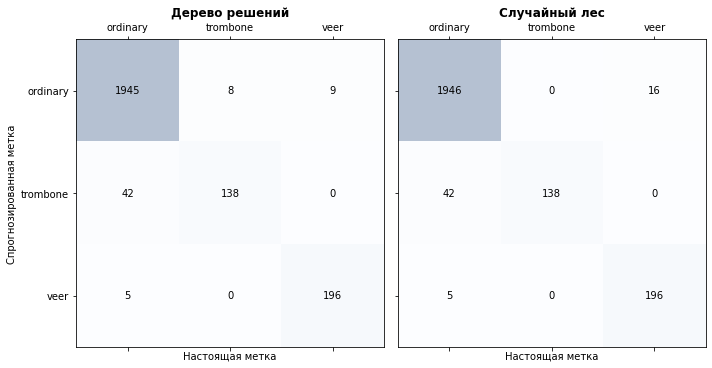

In [395]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), sharey=True)

models = [best_tree, best_forest]

axs[0].set_ylabel('Спрогнозированная метка')
axs[0].set_title('Дерево решений', weight='bold')
axs[1].set_title('Случайный лес', weight='bold')

for ax, model in zip(axs, models):
    confmat = confusion_matrix(y_true=y_t, y_pred=model.predict(X_t))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(
                x=j,
                y=i,
                s=confmat[i, j],
                va='center',
                ha='center'
            )

    ax.set_xlabel('Настоящая метка')
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(target_le.inverse_transform([0, 1, 2]))

plt.yticks(np.arange(3), target_le.inverse_transform([0, 1, 2]))
plt.tight_layout()
plt.show()

In [408]:
names = ['Дерево решений', 'Случайный лес']

for model, name in zip(models, names):
    confmat = confusion_matrix(y_true=y_t, y_pred=model.predict(X_t))
    
    total_entries = confmat.sum()
    correct_predictions = (confmat * np.eye(3)).sum()
    
    print(f'{name}: Корректно распознано {int(correct_predictions)} образцов из {total_entries}.')

Дерево решений: Корректно распознано 2279 образцов из 2343.
Случайный лес: Корректно распознано 2280 образцов из 2343.


In [409]:
for model, name in zip(models, names):
    scores = cross_val_score(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='accuracy'
    )
    print('Точность перекрёстной проверки: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), name))

Точность перекрёстной проверки: 0.99 (+/- 0.01) [Дерево решений]
Точность перекрёстной проверки: 0.99 (+/- 0.01) [Случайный лес]


Обе модели показывают низкое смещение и низкую дисперсию, а значит, хорошо обобщаются на новые данные.

In [412]:
import os

paths = ['flattern_model_tree.pkl', 'flattern_model_forest.pkl']
for path, name in zip(paths, names):
    print('Размер бинарника модели %s - %0.1fКб' % (name, os.path.getsize(path) / 1024))

Размер бинарника модели Дерево решений - 4.8Кб
Размер бинарника модели Случайный лес - 115.2Кб


In [413]:
%%timeit
best_tree.predict(X_t.sample(1))

1.23 ms ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [415]:
%%timeit
best_forest.predict(X_t.sample(1))

14.3 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [416]:
%%timeit
best_tree.predict(X_t.sample(100))

1.21 ms ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [417]:
%%timeit
best_forest.predict(X_t.sample(100))

14.1 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [418]:
%%timeit
best_tree.predict(X_t.sample(1000))

1.32 ms ± 99.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [419]:
%%timeit
best_forest.predict(X_t.sample(1000))

19.3 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Таким образом, как по времени, так и по используемой памяти, лучше всего себя показала модель на основе дерева решений.

# Добавление обработки пустых значений в итоговый оценщик

In [195]:
col_selector = ColumnTransformer([
    ('nothing', 'passthrough', selected_featues),
], remainder='drop')

In [492]:
from sklearn.preprocessing import FunctionTransformer

def nan_dropper_func(df):
    return df.dropna()

nan_dropper = FunctionTransformer(nan_dropper_func)

In [550]:
from sklearn.base import clone

tree_pipe = Pipeline([
    ('prep_dropna', nan_dropper),
    ('prep_select', col_selector),
    ('tree', clone(best_tree.named_steps['tree']))
])

In [551]:
tree_extd = tree_pipe.fit(X_train, y_train)

In [552]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=tree_extd.predict(X_test))

array([[533,   0,   5],
       [  7,   9,   0],
       [  1,   0,  75]], dtype=int64)

In [562]:
accuracy_score(y_true=y_train, y_pred=tree_extd.predict(X_train))

0.9863945578231292

In [553]:
accuracy_score(y_true=y_test, y_pred=tree_extd.predict(X_test))

0.9793650793650793

In [572]:
idxx = ['1', '3']
frame[frame.isna().any(axis=1)][idxx]

,1,3
0,0.0,1.0
1,NaN,3.0
3,NaN,NaN


In [554]:
accuracy_score(y_true=y_t, y_pred=tree_extd.predict(X_t))

0.9743918053777209

In [555]:
confusion_matrix(y_true=y_t, y_pred=tree_extd.predict(X_t))

array([[1949,    0,   13],
       [  42,  138,    0],
       [   5,    0,  196]], dtype=int64)

In [556]:
t = tree_extd.named_steps['tree']
feat_imps = dict(zip(selected_featues, t.feature_importances_))
feat_imps

{'StdDevDist': 0.022788063806391916,
 'MeanDist': 0.01836597531832966,
 'StdDevDistm1': 0.019220009697109196,
 'MeanDistm1': 0.062451607088952914,
 'MeanAzChangem1': 0.05000678819481289,
 'StdDevDistToLast': 0.8133409868249744,
 'MeanDistToLast': 0.013258956581962309,
 'LastAnglChange': 0.0005676124874667706}

# Обучение оценщика на полном наборе данных

In [557]:
full = pd.concat([train, test], axis=0)
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4443 entries, 0 to 2342
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CatalogStId       4443 non-null   int64  
 1   SidStarID         4443 non-null   int64  
 2   Number            4443 non-null   int64  
 3   RouteL            4443 non-null   int64  
 4   ProcedureType     4443 non-null   object 
 5   StdDevDist        4443 non-null   float64
 6   MeanDist          4443 non-null   float64
 7   StdDevDistm1      4443 non-null   float64
 8   MeanDistm1        4443 non-null   float64
 9   MeanAzChangem1    4443 non-null   float64
 10  StdAzChangem1     4443 non-null   float64
 11  StdDevDistToLast  4443 non-null   float64
 12  MeanDistToLast    4443 non-null   float64
 13  LastAnglChange    4443 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 520.7+ KB


In [558]:
Xtra = full.drop(columns=['ProcedureType'])
ytra = full['ProcedureType']

In [559]:
ytra = target_le.transform(ytra)

In [560]:
tree = tree_extd.fit(Xtra, ytra)

In [561]:
with open('flattern_model_tree.pkl', 'wb') as file:
    dill.dump(
        {
            'model': tree,
            'label_encoder': target_le,
            'metadata': {
                'name': 'Flight pattern classification model for simulation modelling.',
                'author': 'Nikolay Popov',
                'version': 2,
                'date': datetime.datetime.now(),
                'type': type(tree.named_steps['tree']).__name__,
                'test_accuracy': accuracy_score(y_true=y_t, y_pred=tree.predict(X_t))
            }
        }, file
    )